### import gym 
gym.version.VERSION

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from gridworld_env import GridworldEnv

In [2]:
env = GridworldEnv('') # Number of plan 

/Users/samueloliveira/opt/anaconda3/envs/maai-env/lib/python3.12/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


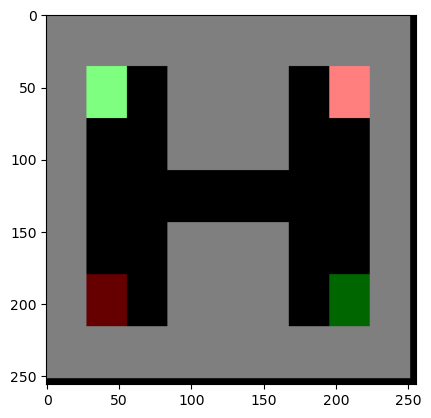

In [3]:
env.render()

In [4]:
env.observation_space

Box(-1.0, [8. 9. 8. 9. 5. 1. 5. 1.], (8,), float32)

In [5]:
print(env.reset())
#print(env.action_space.sample())
env.step([env.action_space[0].sample(),env.action_space[1].sample()])
#env.step(env.action_space.sample())

[1, 1, 1, 7, 0.0, 0.0, 0.0, 0.0]


(array([1, 2, 1, 6, 4, 0, 3, 0]), [0.0, 0.0], [False, False])

In [6]:
env.verbose = True
print( env._get_agents_start_target_state())

((1, 1), (5, 7), (1, 7), (5, 1))


In [7]:
env.grid_map_shape

(7, 9)

In [8]:
env.observation_space

Box(-1.0, [8. 9. 8. 9. 5. 1. 5. 1.], (8,), float32)

In [9]:
env.action_space

{0: Discrete(5), 1: Discrete(5)}

State 				 - Reward
[1 2 1 6 4 0 3 0] 			 [0.0, 0.0]
[5 7 5 2 2 1 3 1] 			 [0.0, 0.0]
Total episode reward:  2.0


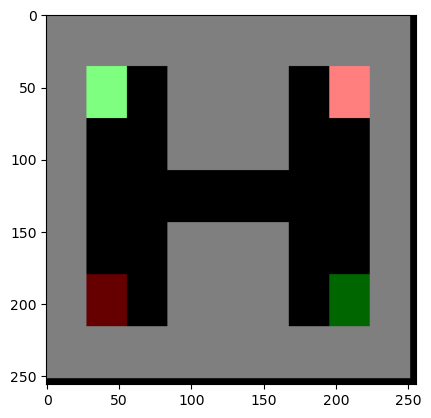

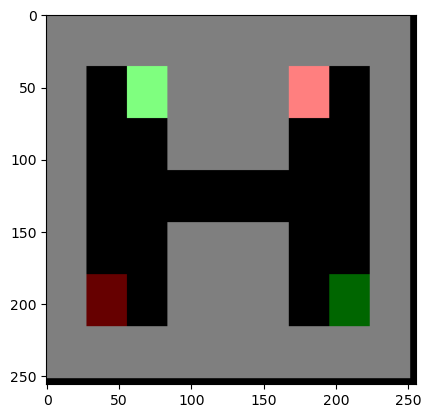

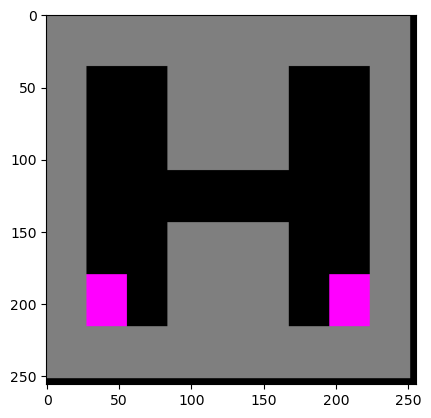

In [10]:
# Try random policy, seems to work
env.reset()
env.render()
print('State \t\t\t\t - Reward')

for i in range(1000):
    move0,move1 = env.action_space[0].sample(),env.action_space[1].sample()
    #move0=1
    #move1=1
    obs , rewards, move_completed =  env.step([move0,move1]) 

    if i%500==0: 
        print(obs,'\t\t\t',rewards)
        env.render()
    
print('Total episode reward: ', env.episode_total_reward)

## Q-learning Example

In [11]:
# Q learning params
ALPHA = 0.2 # learning rate
GAMMA = 0.95 # reward discount
LEARNING_COUNT = 2000
TEST_COUNT = 100

TURN_LIMIT = 1000
IS_MONITOR = True
from algorithms.Q_Learning import Q_Learning_Agents


env = GridworldEnv('')
env.reset()
agents = Q_Learning_Agents(env,LEARNING_COUNT,TURN_LIMIT,ALPHA,GAMMA)

print("###### LEARNING #####")
reward_total_1 = 0.0
reward_total_2 = 0.0
for i in range(LEARNING_COUNT):
    epsilon = agents.update_epsilon(i)
    total_reward,reward_1,reward_2=agents.learn(epsilon)
    reward_total_1 += reward_1
    reward_total_2 += reward_2
print("episodes      : {}".format(LEARNING_COUNT))
print("agent 1 total reward  : {}".format(reward_total_1))
print("agent 1 average reward: {:.2f}".format(reward_total_1 / LEARNING_COUNT))
#print("agent 1 Q Value       :{}".format(agent.q_val))
print("agent 2 total reward  : {}".format(reward_total_2))
print("agent 2 average reward: {:.2f}".format(reward_total_2 / LEARNING_COUNT))
#print("agent 2 Q Value       :{}".format(agent2.q_val))

"""
print("###### TEST #####")
reward_total_1 = 0.0
reward_total_2 = 0.0
for i in range(TEST_COUNT):
    reward_total_1 += agent1.test()
    reward_total_2 += agent2.test()
print("episodes      : {}".format(TEST_COUNT))
print("agent 1 total reward  : {}".format(reward_total_1))
print("agent 1 average reward: {:.2f}".format(reward_total_1 / TEST_COUNT))
print("agent 2 total reward  : {}".format(reward_total_2))
print("agent 2 average reward: {:.2f}".format(reward_total_2 / TEST_COUNT))
"""


###### LEARNING #####
episodes      : 2000
agent 1 total reward  : -1849258.0
agent 1 average reward: -924.63
agent 2 total reward  : -228539.0
agent 2 average reward: -114.27


'\nprint("###### TEST #####")\nreward_total_1 = 0.0\nreward_total_2 = 0.0\nfor i in range(TEST_COUNT):\n    reward_total_1 += agent1.test()\n    reward_total_2 += agent2.test()\nprint("episodes      : {}".format(TEST_COUNT))\nprint("agent 1 total reward  : {}".format(reward_total_1))\nprint("agent 1 average reward: {:.2f}".format(reward_total_1 / TEST_COUNT))\nprint("agent 2 total reward  : {}".format(reward_total_2))\nprint("agent 2 average reward: {:.2f}".format(reward_total_2 / TEST_COUNT))\n'

In [12]:

Q_a1 = agents.q_val_1
Q_a1_fixed_p2=Q_a1[:,:,1,7,:,:,:]
#Q_a1_fixed_p2=Q_a1
Q_a1_mean=np.mean(Q_a1_fixed_p2,axis=tuple(i for i in range(Q_a1_fixed_p2.ndim) if i != 0 and i!=1 and i!=4))

#print(Q_a1_mean[:,:,0])
policy_function1 = np.argmax(Q_a1_mean , axis = 2)

Q_a2 = agents.q_val_2 
Q_a2_fixed_p1=Q_a2[1,1,:,:,:,:,:]
#Q_a2_fixed_p1=Q_a2
#print(Q_a2_fixed_p1.shape)
Q_a2_mean=np.mean(Q_a2_fixed_p1,axis=tuple(i for i in range(Q_a2_fixed_p1.ndim) if i != 0 and i!=1 and i!=4))

policy_function2 = np.argmax( Q_a2_mean , axis = 2)
#print(policy_function1)
#print(policy_function2)

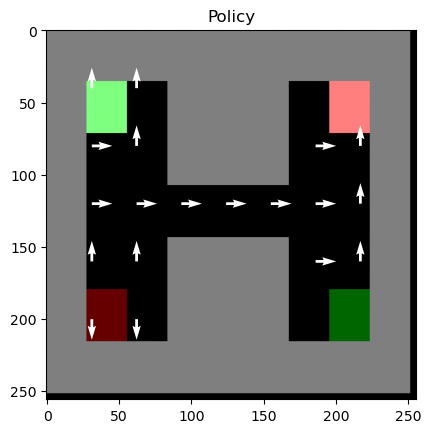

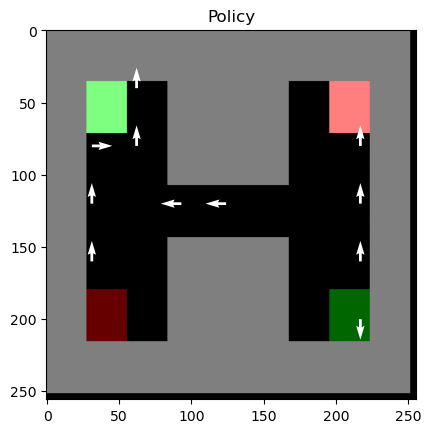

In [152]:
def plot_policy( policy_function ):

    #plt.figure()
    env.reset()
    img=env.render('rgb_array')

    plt.imshow( img.astype('float')/255.0)

    
    for row in range( policy_function.shape[0] ):
        for col in range( policy_function.shape[1] ):
            if policy_function[row,col] == 0:
                continue 
            if policy_function[row,col] == 1:
                dx = 0; dy = .5
            if policy_function[row,col] == 2:
                dx = 0; dy = -.5
            if policy_function[row,col] == 3:
                dx = -.5; dy = 0
            if policy_function[row,col] == 4:
                dx = .5; dy = 0
            plt.arrow( col*31 , row*41 , dx , dy ,shape='full', fc='w' , ec='w' ,lw=3, head_width=3)
            #plt.quiver(col*31,row*40,dx,dy ,color=(1.0,1.0,1.0))
    plt.title( 'Policy' )        
    plt.show() 
plot_policy(policy_function1)
plot_policy(policy_function2)

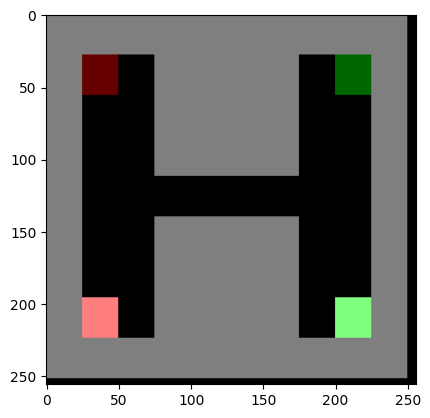

In [ ]:
env.reset()
env.render()